# **Import Libraries**

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #creating visualizations
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor


# **Data Preprocessing**


In [57]:
# Load the dataset
data = pd.read_csv('/kaggle/input/amazon/AmazonSalesData.csv')
data.head() # Display the first 5 rows of the dataset

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,5/28/2010,669165933,6/27/2010,9925,255.28,159.42,2533654.00,1582243.50,951410.50
1,Central America and the Caribbean,Grenada,Cereal,Online,C,8/22/2012,963881480,9/15/2012,2804,205.70,117.11,576782.80,328376.44,248406.36
2,Europe,Russia,Office Supplies,Offline,L,5/2/2014,341417157,5/8/2014,1779,651.21,524.96,1158502.59,933903.84,224598.75
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,6/20/2014,514321792,7/5/2014,8102,9.33,6.92,75591.66,56065.84,19525.82
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,2/1/2013,115456712,2/6/2013,5062,651.21,524.96,3296425.02,2657347.52,639077.50


In [58]:
# Select relevant columns for analysis
data = data[['Order Date','Total Profit']]
print(data.head())

# Check for missing values in the DataFrame
missing_values = data.isnull().any()
if missing_values.any():
    print("Missing values detected!")

  Order Date  Total Profit
0  5/28/2010     951410.50
1  8/22/2012     248406.36
2   5/2/2014     224598.75
3  6/20/2014      19525.82
4   2/1/2013     639077.50


In [59]:
# Convert 'Order Date' to datetime format for easier manipulation
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Extract the year from the 'Order Date' and create a new column
data['Year'] = data['Order Date'].dt.year

# Group data by year to calculate total profit per year
yearly_profit = data.groupby('Year')['Total Profit'].sum().reset_index()

# Create a feature for the sum of profits from the previous three years
yearly_profit['Previous3Years'] = yearly_profit['Total Profit'].shift(1).rolling(window=3).sum()
yearly_profit['Previous3Years'] = yearly_profit['Previous3Years'].fillna(0) # Fill NaN values with 0

# Display the result
#print(yearly_profit)

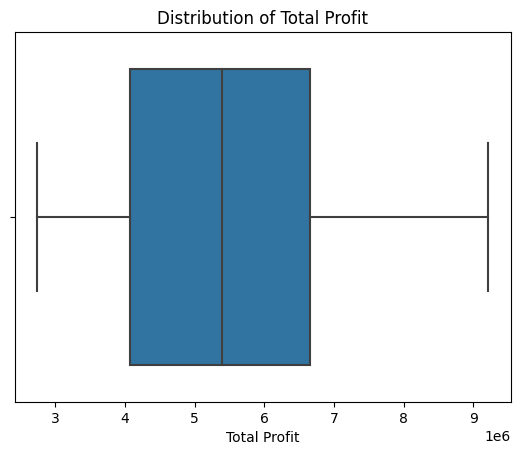

------------------------------------------------------------

No outliers detected using Z-Score Analysis.


In [60]:
# Use Multiple Techniques to Check for Outliers

sns.boxplot(x='Total Profit', data=yearly_profit)
plt.title('Distribution of Total Profit')
plt.show()

# Outlier detection using Z-Score
# Calculate Z-Scores for 'Total Profit'
z_scores = (data['Total Profit'] - np.mean(data['Total Profit'])) / np.std(data['Total Profit'])
outliers = data['Total Profit'][np.abs(z_scores) > 3]
print("------------------------------------------------------------\n")

# Print outliers if detected
if outliers.empty:
    print("No outliers detected using Z-Score Analysis.")
else:
    print("Outliers detected using Z-Score Analysis:")
    print(outliers)

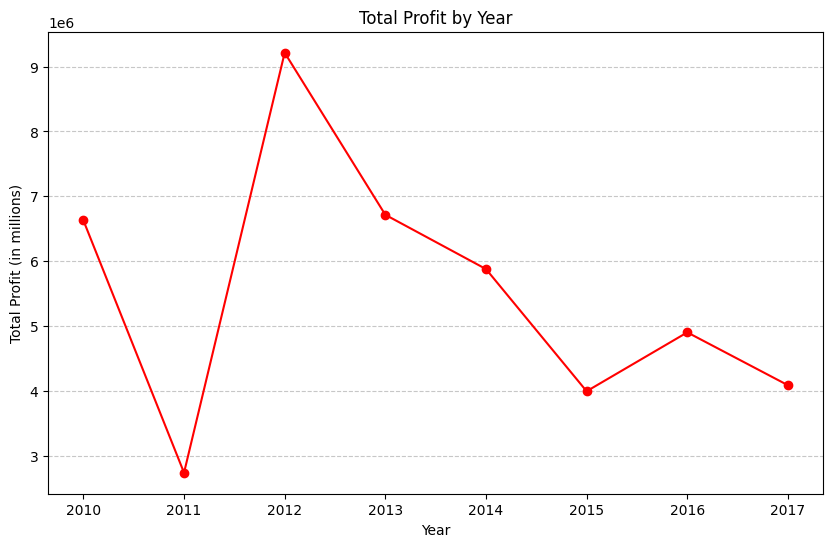

In [61]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(yearly_profit['Year'], yearly_profit['Total Profit'], color='red', marker='o')  # Using 'Close*' column
plt.title('Total Profit by Year')
plt.xlabel('Year')
plt.ylabel('Total Profit (in millions)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Model**

In [62]:
# Prepare features (X) and target variable (y) for the model
X = yearly_profit[['Year', 'Previous3Years']]
y = yearly_profit['Total Profit']

In [63]:
# Initialize the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Calculate mean and standard deviation of MAE scores
mae_scores = -cv_scores  # Convert to positive
print(f'Mean MAE: {mae_scores.mean()}')
print(f'Standard Deviation of MSE: {mae_scores.std()}')

# Fit the model to the entire dataset after cross-validation
model.fit(X, y)

# Generate predictions on the training data
y_train_pred = model.predict(X)

Mean MAE: 1914528.1501299995
Standard Deviation of MSE: 1351321.0810248745


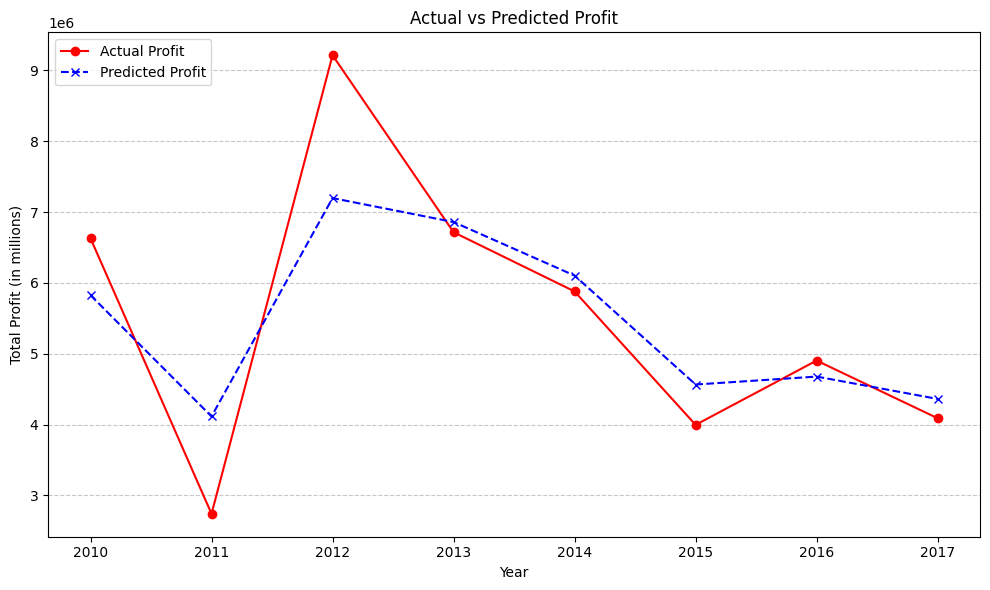

In [64]:
# Create a DataFrame to compare actual vs. predicted profits
training_results = pd.DataFrame({
    'Year': X['Year'],
    'Actual Profit': y,
    'Predicted Profit': y_train_pred
})

# Sort the results by Year for better visualization
training_results = training_results.sort_values(by='Year')

# Plotting actual vs. predicted profits for training data
plt.figure(figsize=(10, 6))
plt.plot(training_results['Year'], training_results['Actual Profit'], label='Actual Profit', color='red', marker='o')
plt.plot(training_results['Year'], training_results['Predicted Profit'], label='Predicted Profit', color='blue', linestyle='--', marker='x')
plt.title('Actual vs Predicted Profit')
plt.xlabel('Year')
plt.ylabel('Total Profit (in millions)')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# **Predictions**

In [65]:
# Generate predictions for the next year
latest_year = yearly_profit['Year'].max()
future_year = latest_year + 1
previous_profit = yearly_profit[yearly_profit['Year'] <= latest_year]['Total Profit'].tail(3).sum()

# Create a DataFrame for future predictions
future_data = pd.DataFrame({
    'Year': [future_year],
    'Previous3Years': [previous_profit]
})

# Make the prediction for the next year
predicted_profit = model.predict(future_data)
print(f'Predicted Profit for {future_year}: {predicted_profit[0]}')

Predicted Profit for 2018: 4362163.6726999935


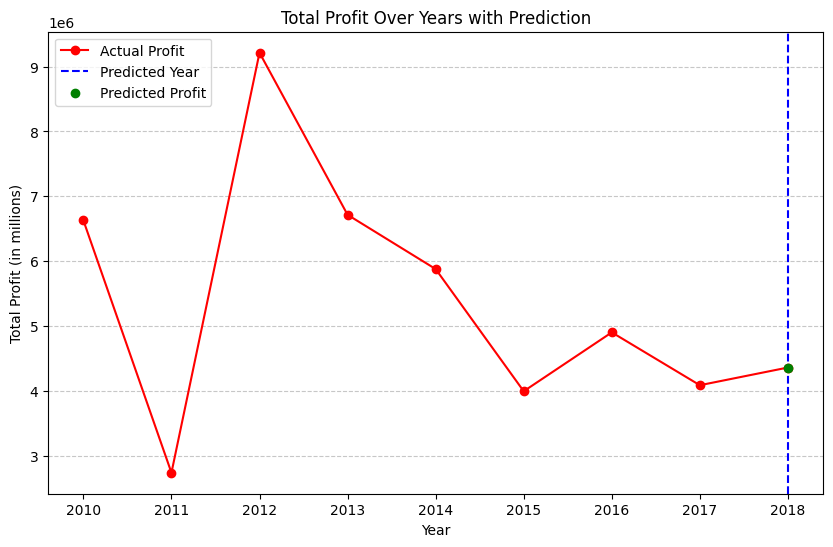

In [66]:
# Append the predicted profit to the yearly profit DataFrame
predicted_df = pd.DataFrame({
    'Year': [future_year],
    'Total Profit': [predicted_profit[0]],
    'Previous3Years': [previous_profit]
})

# Combine actual and predicted data for visualization
combined_profit = pd.concat([yearly_profit, predicted_df], ignore_index=True)

# Plotting total profit by year with prediction
plt.figure(figsize=(10, 6))
plt.plot(combined_profit['Year'], combined_profit['Total Profit'], label='Actual Profit', color='red', marker='o')
plt.axvline(x=future_year, color='blue', linestyle='--', label='Predicted Year')
plt.scatter(future_year, predicted_profit[0], color='green', label='Predicted Profit', zorder=5)
plt.title('Total Profit Over Years with Prediction')
plt.xlabel('Year')
plt.ylabel('Total Profit (in millions)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()